# Exploring Breast Cancer Diagnosis Stage in NY State

#### Things to do 

- read up on what affects breast cancer diagnosis?
- why isn't new york showing up even if it is there?
- do any other linear models work?
- add health insurance to census

## Set Up

In [1]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Load all the packages

In [4]:
%%R 

library(tidycensus)
library(tidyverse)
library(sf)
library(DescTools)
require(flexplot)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Linking to GEOS 3.13.0, GDAL 3.10.2, PROJ 9.5.1; sf_use_s2() is TRUE
Loading required package: flexplot
In addition: Warning message:
In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
  there is no package called ‘flexplot’


In [5]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

In [6]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Getting the Census Dataset I want

In [7]:
%%R 

# this code is incomplete, refer to example notebooks
# and use chat gpt for help getting census variables
ny_census_data <- get_acs(geography = "county", 
                      state='NY',
                      variables = c(
                          # education
                          female_25_pop = "B15002_019", #total female population 25 and older
                        bachelors = "B15002_032", #  bachelors degree female
                          masters = "B15002_033", #masters degree females
                          doctorate = "B15002_035", #doctorate degree females
                          
                          #poverty and income
                          total_population_poverty = "B17001_001", #total population under poverty
                          female_poverty = "B17001_017", #female population under poverty
                          
                          med_inc = "B19013_001", # median household income
                          
                          #race - doesn't have gender
                            white_pop = "B01001A_017", # white alone females
                           black_pop = "B01001B_017", #black alone females
                           hispanic_latino = "B01001I_017", #hispanic or latino alone females
                          
                          #insurance
                              under6    = "B27001_032",
                              age6_18   = "B27001_035",
                              age19_25  = "B27001_038",
                              age26_34  = "B27001_041",
                              age35_44  = "B27001_044",
                              age45_54  = "B27001_047",
                              age55_64  = "B27001_050",
                              age65_74  = "B27001_053",
                              age75plus = "B27001_056",

                          
                          #population
                         total_pop = "B01001_001",  #Total population
                         female_pop = "B01001_026" #Total female population
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)
                   

ny_census_data

Simple feature collection with 1302 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -79.76215 ymin: 40.4961 xmax: -71.85621 ymax: 45.01585
Geodetic CRS:  NAD83
First 10 features:
   GEOID                      NAME                 variable estimate moe
1  36017 Chenango County, New York                total_pop    47407  NA
2  36017 Chenango County, New York               female_pop    23587  51
3  36017 Chenango County, New York                white_pop    22527 106
4  36017 Chenango County, New York                black_pop      165  58
5  36017 Chenango County, New York          hispanic_latino      469  18
6  36017 Chenango County, New York            female_25_pop    17050  62
7  36017 Chenango County, New York                bachelors     1767 222
8  36017 Chenango County, New York                  masters     1460 203
9  36017 Chenango County, New York                doctorate       76  40
10 36017 Chenango County, New York total_populatio

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'


### Load our breast cancer rates 

In [8]:
df = pd.read_csv("breast_cancer_stages_NY.csv")
df.head()

,County,Stage,Percent
0,Broome,Local,73.9
1,Cattaraugus,Local,69.3
2,Cayuga,Local,74.8
3,Chautauqua,Local,72.0
4,Chemung,Local,65.6


In [9]:
breast_cancer_ny = df.pivot_table(index="County", 
                             columns="Stage", 
                             values="Percent")

breast_cancer_ny = breast_cancer_ny.reset_index()
breast_cancer_ny.columns.name = None


breast_cancer_ny.head()

,County,Distant,Local,Regional,Unknown
0,Albany,4.9,71.3,22.5,1.4
1,Allegany,6.3,74.4,17.0,2.3
2,Bronx,7.6,61.4,28.1,2.8
3,Broome,4.6,73.9,20.3,1.2
4,Cattaraugus,7.5,69.3,20.9,2.3


## Clean Up Our Census Data

In [10]:
%%R 
#pivot wider
# moe is margin of error

ny_census_data <- ny_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

ny_census_data

Simple feature collection with 62 features and 44 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -79.76215 ymin: 40.4961 xmax: -71.85621 ymax: 45.01585
Geodetic CRS:  NAD83
# A tibble: 62 × 45
   GEOID NAME                    geometry total_pop_estimate female_pop_estimate
   <chr> <chr>         <MULTIPOLYGON [°]>              <dbl>               <dbl>
 1 36017 Chena… (((-75.88983 42.72384, -…              47407               23587
 2 36119 Westc… (((-73.77278 40.8846, -7…             999723              512430
 3 36025 Delaw… (((-75.42264 42.05591, -…              44644               22004
 4 36115 Washi… (((-73.63622 43.49824, -…              61504               29428
 5 36075 Osweg… (((-76.61693 43.41804, -…             118019               58647
 6 36067 Onond… (((-76.49931 43.09795, -…             474621              244319
 7 36113 Warre… (((-74.21462 43.7287, -7…              65692               33195
 8 36051 Livin… (((-78.06075 42.53671, -…          

In [11]:
%%R

#name it be the same name as the county in our dataset

ny_census_data <- ny_census_data %>%
    mutate(
        county = str_split(NAME, " ") %>% map_chr(1) %>% str_trim(),
    )

In [12]:
%%R
ny_census_data %>% 
    select(NAME, county)

Simple feature collection with 62 features and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -79.76215 ymin: 40.4961 xmax: -71.85621 ymax: 45.01585
Geodetic CRS:  NAD83
# A tibble: 62 × 3
   NAME                         county                                  geometry
   <chr>                        <chr>                         <MULTIPOLYGON [°]>
 1 Chenango County, New York    Chenango    (((-75.88983 42.72384, -75.82109 42…
 2 Westchester County, New York Westchester (((-73.77278 40.8846, -73.77228 40.…
 3 Delaware County, New York    Delaware    (((-75.42264 42.05591, -75.42262 42…
 4 Washington County, New York  Washington  (((-73.63622 43.49824, -73.63453 43…
 5 Oswego County, New York      Oswego      (((-76.61693 43.41804, -76.60709 43…
 6 Onondaga County, New York    Onondaga    (((-76.49931 43.09795, -76.49922 43…
 7 Warren County, New York      Warren      (((-74.21462 43.7287, -74.05875 43.…
 8 Livingston County, New York  Livingston  (((-78.06

In [13]:
%%R -o ny_census_data_py

ny_census_data_py <- ny_census_data %>%
  st_drop_geometry() %>%  # Remove the spatial geometry
  as.data.frame()  


In [14]:
ny_census_data_py.loc[ny_census_data_py['county'] == 'New', 'county'] = "New York"

## Join our Breast Cancer dataset and Census

In [15]:
merged_df = breast_cancer_ny.merge(ny_census_data_py, left_on = "County", right_on = "county", how = "left")

merged_df.head()

,County,Distant,Local,Regional,Unknown,GEOID,NAME,total_pop_estimate,female_pop_estimate,white_pop_estimate,black_pop_estimate,hispanic_latino_estimate,female_25_pop_estimate,bachelors_estimate,masters_estimate,doctorate_estimate,total_population_poverty_estimate,female_poverty_estimate,med_inc_estimate,under6_estimate,age6_18_estimate,age19_25_estimate,age26_34_estimate,age35_44_estimate,age45_54_estimate,age55_64_estimate,age65_74_estimate,age75plus_estimate,total_pop_moe,female_pop_moe,white_pop_moe,black_pop_moe,hispanic_latino_moe,female_25_pop_moe,bachelors_moe,masters_moe,doctorate_moe,total_population_poverty_moe,female_poverty_moe,med_inc_moe,under6_moe,age6_18_moe,age19_25_moe,age26_34_moe,age35_44_moe,age45_54_moe,age55_64_moe,age65_74_moe,age75plus_moe,county
0,Albany,4.9,71.3,22.5,1.4,36001,"Albany County, New York",314679.0,161680.0,119025.0,19638.0,10120.0,109992.0,23543.0,18813.0,2564.0,298762.0,19093.0,73810.0,8569.0,23132.0,21368.0,17213.0,18104.0,18637.0,20935.0,16605.0,11813.0,NaN,83.0,604.0,965.0,NaN,67.0,959.0,1077.0,367.0,902.0,1321.0,2387.0,275.0,503.0,539.0,423.0,214.0,157.0,204.0,72.0,308.0,Albany
1,Allegany,6.3,74.4,17.0,2.3,36003,"Allegany County, New York",46654.0,23052.0,21891.0,377.0,535.0,15076.0,2020.0,1584.0,112.0,41571.0,3486.0,54375.0,1227.0,3730.0,2515.0,1816.0,2208.0,2536.0,3165.0,2577.0,1767.0,NaN,128.0,74.0,96.0,60.0,88.0,252.0,163.0,26.0,422.0,372.0,1505.0,124.0,197.0,168.0,83.0,63.0,43.0,105.0,20.0,93.0,Allegany
2,Bronx,7.6,61.4,28.1,2.8,36005,"Bronx County, New York",1468262.0,772461.0,153016.0,269597.0,434648.0,522309.0,73429.0,36184.0,3162.0,1433574.0,215657.0,43726.0,59232.0,124881.0,68306.0,94859.0,89970.0,88986.0,86656.0,59769.0,47799.0,NaN,215.0,4224.0,3029.0,NaN,244.0,2512.0,1584.0,532.0,1399.0,4979.0,745.0,918.0,1256.0,1481.0,1190.0,757.0,888.0,616.0,408.0,549.0,Bronx
3,Broome,4.6,73.9,20.3,1.2,36007,"Broome County, New York",198591.0,100258.0,84435.0,5537.0,4447.0,67946.0,9949.0,7596.0,991.0,188745.0,19080.0,53982.0,5741.0,14392.0,12089.0,9326.0,10060.0,10865.0,13616.0,10645.0,9466.0,NaN,42.0,398.0,439.0,NaN,23.0,643.0,566.0,239.0,1033.0,1257.0,1835.0,186.0,390.0,430.0,274.0,186.0,156.0,218.0,98.0,147.0,Broome
4,Cattaraugus,7.5,69.3,20.9,2.3,36009,"Cattaraugus County, New York",77211.0,38525.0,35041.0,351.0,725.0,26797.0,2948.0,2686.0,122.0,74788.0,6814.0,53537.0,2249.0,5998.0,2912.0,3248.0,4081.0,4558.0,5592.0,4425.0,3199.0,NaN,96.0,117.0,90.0,52.0,69.0,234.0,281.0,58.0,346.0,571.0,1681.0,150.0,190.0,137.0,150.0,88.0,99.0,76.0,54.0,109.0,Cattaraugus


In [16]:
merged_df.shape

(62, 50)

In [17]:
merged_df.drop(columns = ["NAME","county"], axis = 1, inplace = True)

## Analysis

First we need to calculate some percentages before we can run linear regressions.

In [18]:
merged_df[merged_df["County"] == "Albany"]

,County,Distant,Local,Regional,Unknown,GEOID,total_pop_estimate,female_pop_estimate,white_pop_estimate,black_pop_estimate,hispanic_latino_estimate,female_25_pop_estimate,bachelors_estimate,masters_estimate,doctorate_estimate,total_population_poverty_estimate,female_poverty_estimate,med_inc_estimate,under6_estimate,age6_18_estimate,age19_25_estimate,age26_34_estimate,age35_44_estimate,age45_54_estimate,age55_64_estimate,age65_74_estimate,age75plus_estimate,total_pop_moe,female_pop_moe,white_pop_moe,black_pop_moe,hispanic_latino_moe,female_25_pop_moe,bachelors_moe,masters_moe,doctorate_moe,total_population_poverty_moe,female_poverty_moe,med_inc_moe,under6_moe,age6_18_moe,age19_25_moe,age26_34_moe,age35_44_moe,age45_54_moe,age55_64_moe,age65_74_moe,age75plus_moe
0,Albany,4.9,71.3,22.5,1.4,36001,314679.0,161680.0,119025.0,19638.0,10120.0,109992.0,23543.0,18813.0,2564.0,298762.0,19093.0,73810.0,8569.0,23132.0,21368.0,17213.0,18104.0,18637.0,20935.0,16605.0,11813.0,NaN,83.0,604.0,965.0,NaN,67.0,959.0,1077.0,367.0,902.0,1321.0,2387.0,275.0,503.0,539.0,423.0,214.0,157.0,204.0,72.0,308.0


In [19]:
# percent of women above 25 that have a higher degree (should I include professional?)
merged_df["pct_higher_ed"] = ((merged_df["bachelors_estimate"] + merged_df["masters_estimate"] + merged_df["doctorate_estimate"]) / merged_df["female_25_pop_estimate"]) * 100

In [20]:
# percent of females in poverty 
merged_df["pct_female_poverty"] = (merged_df["female_poverty_estimate"] / merged_df["female_pop_estimate"]) * 100

In [21]:
# percentage race 
merged_df["pct_white"] = (merged_df["white_pop_estimate"] / merged_df["female_pop_estimate"]) * 100
merged_df["pct_black"] = (merged_df["black_pop_estimate"] / merged_df["female_pop_estimate"]) * 100
merged_df["pct_hisp_lat"] = (merged_df["hispanic_latino_estimate"] / merged_df["female_pop_estimate"]) * 100

In [22]:
merged_df.head()

,County,Distant,Local,Regional,Unknown,GEOID,total_pop_estimate,female_pop_estimate,white_pop_estimate,black_pop_estimate,hispanic_latino_estimate,female_25_pop_estimate,bachelors_estimate,masters_estimate,doctorate_estimate,total_population_poverty_estimate,female_poverty_estimate,med_inc_estimate,under6_estimate,age6_18_estimate,age19_25_estimate,age26_34_estimate,age35_44_estimate,age45_54_estimate,age55_64_estimate,age65_74_estimate,age75plus_estimate,total_pop_moe,female_pop_moe,white_pop_moe,black_pop_moe,hispanic_latino_moe,female_25_pop_moe,bachelors_moe,masters_moe,doctorate_moe,total_population_poverty_moe,female_poverty_moe,med_inc_moe,under6_moe,age6_18_moe,age19_25_moe,age26_34_moe,age35_44_moe,age45_54_moe,age55_64_moe,age65_74_moe,age75plus_moe,pct_higher_ed,pct_female_poverty,pct_white,pct_black,pct_hisp_lat
0,Albany,4.9,71.3,22.5,1.4,36001,314679.0,161680.0,119025.0,19638.0,10120.0,109992.0,23543.0,18813.0,2564.0,298762.0,19093.0,73810.0,8569.0,23132.0,21368.0,17213.0,18104.0,18637.0,20935.0,16605.0,11813.0,NaN,83.0,604.0,965.0,NaN,67.0,959.0,1077.0,367.0,902.0,1321.0,2387.0,275.0,503.0,539.0,423.0,214.0,157.0,204.0,72.0,308.0,40.839334,11.809129,73.617640,12.146215,6.259278
1,Allegany,6.3,74.4,17.0,2.3,36003,46654.0,23052.0,21891.0,377.0,535.0,15076.0,2020.0,1584.0,112.0,41571.0,3486.0,54375.0,1227.0,3730.0,2515.0,1816.0,2208.0,2536.0,3165.0,2577.0,1767.0,NaN,128.0,74.0,96.0,60.0,88.0,252.0,163.0,26.0,422.0,372.0,1505.0,124.0,197.0,168.0,83.0,63.0,43.0,105.0,20.0,93.0,24.648448,15.122332,94.963561,1.635433,2.320840
2,Bronx,7.6,61.4,28.1,2.8,36005,1468262.0,772461.0,153016.0,269597.0,434648.0,522309.0,73429.0,36184.0,3162.0,1433574.0,215657.0,43726.0,59232.0,124881.0,68306.0,94859.0,89970.0,88986.0,86656.0,59769.0,47799.0,NaN,215.0,4224.0,3029.0,NaN,244.0,2512.0,1584.0,532.0,1399.0,4979.0,745.0,918.0,1256.0,1481.0,1190.0,757.0,888.0,616.0,408.0,549.0,21.591625,27.918173,19.808897,34.901050,56.267954
3,Broome,4.6,73.9,20.3,1.2,36007,198591.0,100258.0,84435.0,5537.0,4447.0,67946.0,9949.0,7596.0,991.0,188745.0,19080.0,53982.0,5741.0,14392.0,12089.0,9326.0,10060.0,10865.0,13616.0,10645.0,9466.0,NaN,42.0,398.0,439.0,NaN,23.0,643.0,566.0,239.0,1033.0,1257.0,1835.0,186.0,390.0,430.0,274.0,186.0,156.0,218.0,98.0,147.0,27.280487,19.030900,84.217718,5.522751,4.435556
4,Cattaraugus,7.5,69.3,20.9,2.3,36009,77211.0,38525.0,35041.0,351.0,725.0,26797.0,2948.0,2686.0,122.0,74788.0,6814.0,53537.0,2249.0,5998.0,2912.0,3248.0,4081.0,4558.0,5592.0,4425.0,3199.0,NaN,96.0,117.0,90.0,52.0,69.0,234.0,281.0,58.0,346.0,571.0,1681.0,150.0,190.0,137.0,150.0,88.0,99.0,76.0,54.0,109.0,21.480016,17.687216,90.956522,0.911097,1.881895


In [23]:
merged_df["pct_insured"] = (merged_df["under6_estimate"] + merged_df["age6_18_estimate"] + 
                            merged_df["age19_25_estimate"] + merged_df["age26_34_estimate"] +
                            merged_df["age35_44_estimate"] +merged_df["age45_54_estimate"] +
                            merged_df["age55_64_estimate"] + merged_df["age65_74_estimate"] +
                            merged_df["age75plus_estimate"]) / merged_df["female_pop_estimate"]

merged_df.head()

,County,Distant,Local,Regional,Unknown,GEOID,total_pop_estimate,female_pop_estimate,white_pop_estimate,black_pop_estimate,hispanic_latino_estimate,female_25_pop_estimate,bachelors_estimate,masters_estimate,doctorate_estimate,total_population_poverty_estimate,female_poverty_estimate,med_inc_estimate,under6_estimate,age6_18_estimate,age19_25_estimate,age26_34_estimate,age35_44_estimate,age45_54_estimate,age55_64_estimate,age65_74_estimate,age75plus_estimate,total_pop_moe,female_pop_moe,white_pop_moe,black_pop_moe,hispanic_latino_moe,female_25_pop_moe,bachelors_moe,masters_moe,doctorate_moe,total_population_poverty_moe,female_poverty_moe,med_inc_moe,under6_moe,age6_18_moe,age19_25_moe,age26_34_moe,age35_44_moe,age45_54_moe,age55_64_moe,age65_74_moe,age75plus_moe,pct_higher_ed,pct_female_poverty,pct_white,pct_black,pct_hisp_lat,pct_insured
0,Albany,4.9,71.3,22.5,1.4,36001,314679.0,161680.0,119025.0,19638.0,10120.0,109992.0,23543.0,18813.0,2564.0,298762.0,19093.0,73810.0,8569.0,23132.0,21368.0,17213.0,18104.0,18637.0,20935.0,16605.0,11813.0,NaN,83.0,604.0,965.0,NaN,67.0,959.0,1077.0,367.0,902.0,1321.0,2387.0,275.0,503.0,539.0,423.0,214.0,157.0,204.0,72.0,308.0,40.839334,11.809129,73.617640,12.146215,6.259278,0.967194
1,Allegany,6.3,74.4,17.0,2.3,36003,46654.0,23052.0,21891.0,377.0,535.0,15076.0,2020.0,1584.0,112.0,41571.0,3486.0,54375.0,1227.0,3730.0,2515.0,1816.0,2208.0,2536.0,3165.0,2577.0,1767.0,NaN,128.0,74.0,96.0,60.0,88.0,252.0,163.0,26.0,422.0,372.0,1505.0,124.0,197.0,168.0,83.0,63.0,43.0,105.0,20.0,93.0,24.648448,15.122332,94.963561,1.635433,2.320840,0.934453
2,Bronx,7.6,61.4,28.1,2.8,36005,1468262.0,772461.0,153016.0,269597.0,434648.0,522309.0,73429.0,36184.0,3162.0,1433574.0,215657.0,43726.0,59232.0,124881.0,68306.0,94859.0,89970.0,88986.0,86656.0,59769.0,47799.0,NaN,215.0,4224.0,3029.0,NaN,244.0,2512.0,1584.0,532.0,1399.0,4979.0,745.0,918.0,1256.0,1481.0,1190.0,757.0,888.0,616.0,408.0,549.0,21.591625,27.918173,19.808897,34.901050,56.267954,0.932679
3,Broome,4.6,73.9,20.3,1.2,36007,198591.0,100258.0,84435.0,5537.0,4447.0,67946.0,9949.0,7596.0,991.0,188745.0,19080.0,53982.0,5741.0,14392.0,12089.0,9326.0,10060.0,10865.0,13616.0,10645.0,9466.0,NaN,42.0,398.0,439.0,NaN,23.0,643.0,566.0,239.0,1033.0,1257.0,1835.0,186.0,390.0,430.0,274.0,186.0,156.0,218.0,98.0,147.0,27.280487,19.030900,84.217718,5.522751,4.435556,0.959524
4,Cattaraugus,7.5,69.3,20.9,2.3,36009,77211.0,38525.0,35041.0,351.0,725.0,26797.0,2948.0,2686.0,122.0,74788.0,6814.0,53537.0,2249.0,5998.0,2912.0,3248.0,4081.0,4558.0,5592.0,4425.0,3199.0,NaN,96.0,117.0,90.0,52.0,69.0,234.0,281.0,58.0,346.0,571.0,1681.0,150.0,190.0,137.0,150.0,88.0,99.0,76.0,54.0,109.0,21.480016,17.687216,90.956522,0.911097,1.881895,0.941259


In [24]:
# making a new dataframe with just the analysis variables 

clean_df = merged_df[["County", "Distant", "Local","Regional","Unknown", "med_inc_estimate", "pct_higher_ed", "pct_female_poverty","pct_white","pct_black","pct_hisp_lat", "pct_insured"]]
clean_df.head()

,County,Distant,Local,Regional,Unknown,med_inc_estimate,pct_higher_ed,pct_female_poverty,pct_white,pct_black,pct_hisp_lat,pct_insured
0,Albany,4.9,71.3,22.5,1.4,73810.0,40.839334,11.809129,73.617640,12.146215,6.259278,0.967194
1,Allegany,6.3,74.4,17.0,2.3,54375.0,24.648448,15.122332,94.963561,1.635433,2.320840,0.934453
2,Bronx,7.6,61.4,28.1,2.8,43726.0,21.591625,27.918173,19.808897,34.901050,56.267954,0.932679
3,Broome,4.6,73.9,20.3,1.2,53982.0,27.280487,19.030900,84.217718,5.522751,4.435556,0.959524
4,Cattaraugus,7.5,69.3,20.9,2.3,53537.0,21.480016,17.687216,90.956522,0.911097,1.881895,0.941259


## Run Linear Regressions in R

I want to see if the stage at which diagnosis happens can be predicted by some socioeconomic factors. Local stage is when the cancer is spreading but still localised to the breast i.e Early Stage. Distant stage is when the cancer has spread far and wide and has almost taken over the organs i.e. Late Stage. 

Y1 = Percent of population in the county diagnosed at Local Stage

Y2 = Percent of population in the county diagnosed at Distant Stage 

**We will run these against a bunch of Xs**

X1 = Higher Education Attainment

X2 = Poverty Level

X3 = Median Household Income

X4 = Race (white, black, hisp_lat) - separately? need clarity on this one

### Local ( Y1 ) ~ X ( 1,2,3... )

In [25]:
%%R -i clean_df

model <- lm(Local~pct_higher_ed, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ pct_higher_ed, data = clean_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.3294  -1.6603   0.2829   2.0157   9.9998 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   69.77033    2.02850  34.395   <2e-16 ***
pct_higher_ed -0.01190    0.06496  -0.183    0.855    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.117 on 59 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.0005685,	Adjusted R-squared:  -0.01637 
F-statistic: 0.03356 on 1 and 59 DF,  p-value: 0.8553



In [26]:
## why are two observations deleted?

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



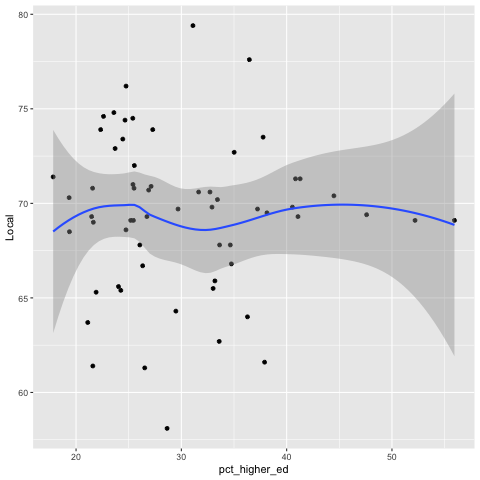

In [27]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_higher_ed, y=Local) + 
    geom_point() +
    geom_smooth()

**Literally no correlation**

In [28]:
%%R -i clean_df

model <- lm(Local~pct_female_poverty, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ pct_female_poverty, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.635  -2.592   0.108   2.251   9.779 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         72.1721     1.9635  36.757   <2e-16 ***
pct_female_poverty  -0.2073     0.1422  -1.458     0.15    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.046 on 59 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.03476,	Adjusted R-squared:  0.0184 
F-statistic: 2.125 on 1 and 59 DF,  p-value: 0.1502



`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



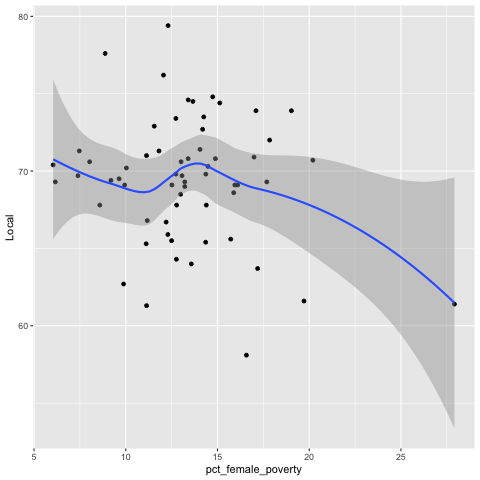

In [29]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_female_poverty, y=Local) + 
    geom_point() +
    geom_smooth()

In [30]:
# Thoughts = maybe I should get individual years of diagnosis stages and then see if that works

In [31]:
%%R -i clean_df

model <- lm(Local~med_inc_estimate, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ med_inc_estimate, data = clean_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.2960  -1.5957   0.1429   1.8692  10.0004 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      6.918e+01  2.267e+00  30.522   <2e-16 ***
med_inc_estimate 3.337e-06  3.241e-05   0.103    0.918    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.118 on 59 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.0001797,	Adjusted R-squared:  -0.01677 
F-statistic: 0.0106 on 1 and 59 DF,  p-value: 0.9183



`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



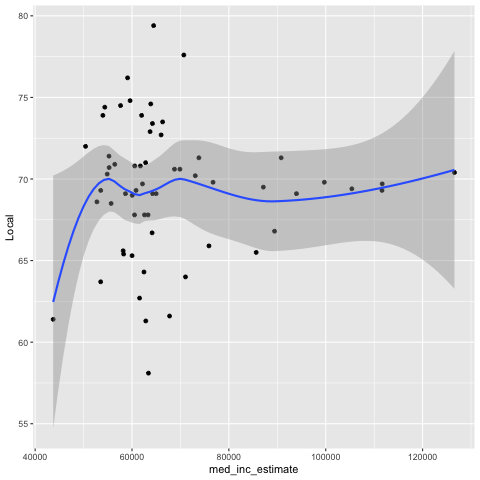

In [32]:
%%R 

ggplot(clean_df) + 
    aes(x=med_inc_estimate, y=Local) + 
    geom_point() +
    geom_smooth()

In [33]:
%%R -i clean_df

model <- lm(Local~pct_white, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ pct_white, data = clean_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.8092  -1.8191   0.3473   2.6207   9.0092 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 61.29005    2.68457  22.831  < 2e-16 ***
pct_white    0.09739    0.03165   3.077  0.00317 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.823 on 59 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.1383,	Adjusted R-squared:  0.1237 
F-statistic: 9.467 on 1 and 59 DF,  p-value: 0.003171



`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



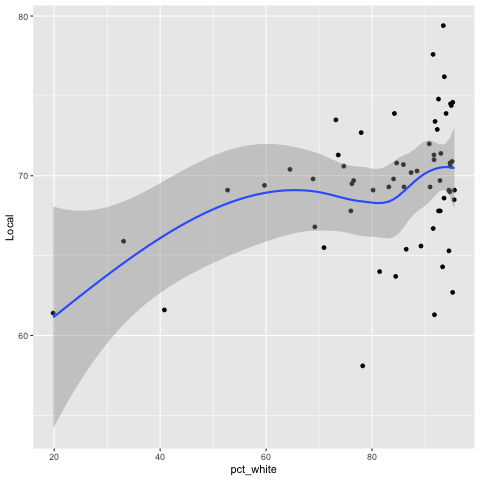

In [34]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_white, y=Local) + 
    geom_point() +
    geom_smooth()

In [35]:
%%R
require(ggrepel)

Loading required package: ggrepel


In [36]:
%%R 

nyc_counties <- c("Bronx", "Kings", 'New York', "Queens", "Richmond")
clean_df <- clean_df %>%
  mutate(is_nyc = County %in% nyc_counties)

In [37]:
%%R

clean_df %>%
    select(County, is_nyc, pct_white, Local)

         County is_nyc pct_white Local
0        Albany  FALSE  73.61764  71.3
1      Allegany  FALSE  94.96356  74.4
2         Bronx   TRUE  19.80890  61.4
3        Broome  FALSE  84.21772  73.9
4   Cattaraugus  FALSE  90.95652  69.3
5        Cayuga  FALSE  92.54017  74.8
6    Chautauqua  FALSE  90.80238  72.0
7       Chemung  FALSE  89.23368  65.6
8      Chenango  FALSE  95.50600  68.5
9       Clinton  FALSE  93.31231  64.3
10     Columbia  FALSE  87.36519  70.2
11     Cortland  FALSE  92.81847  69.7
12     Delaware  FALSE  93.58298  68.6
13     Dutchess  FALSE  76.19051  69.5
14         Erie  FALSE  75.99572  67.8
15        Essex  FALSE  95.21579  62.7
16     Franklin  FALSE  85.91666  70.7
17       Fulton  FALSE  92.97465  71.4
18      Genesee  FALSE  92.30636  72.9
19       Greene  FALSE  91.70229  71.0
20     Hamilton  FALSE  91.77973  61.3
21     Herkimer  FALSE  94.71553  70.8
22    Jefferson  FALSE  86.44663  65.4
23        Kings   TRUE  40.80197  61.6
24        Lewis  FALSE  9

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: There were 19 warnings (use warnings() to see them)
R[write to console]: 



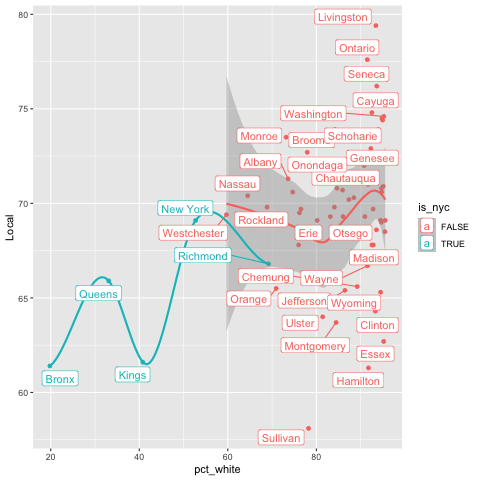

In [38]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_white, y=Local, color = is_nyc) + 
    geom_point() +
    geom_smooth() +
    geom_label_repel(aes(label = County))

In [39]:
%%R

model <- lm(Local~pct_white, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ pct_white, data = clean_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.8092  -1.8191   0.3473   2.6207   9.0092 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 61.29005    2.68457  22.831  < 2e-16 ***
pct_white    0.09739    0.03165   3.077  0.00317 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.823 on 59 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.1383,	Adjusted R-squared:  0.1237 
F-statistic: 9.467 on 1 and 59 DF,  p-value: 0.003171



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



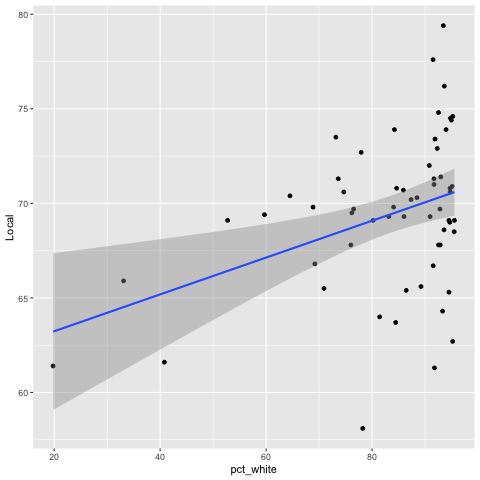

In [40]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_white, y=Local) + 
    geom_point() +
    geom_smooth(method = "lm")

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



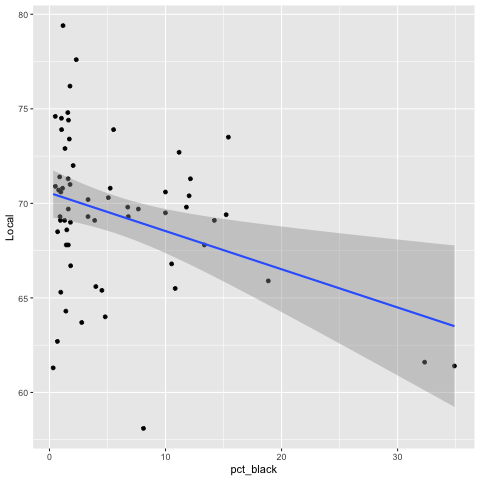

In [41]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_black, y=Local) + 
    geom_point() +
    geom_smooth(method = "lm")

In [42]:
%%R 

model <- lm(Local~pct_hisp_lat, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ pct_hisp_lat, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8775 -1.5011  0.3296  2.5339  9.2043 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   70.8164     0.6346 111.592   <2e-16 ***
pct_hisp_lat  -0.1784     0.0524  -3.404   0.0012 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.765 on 59 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.1642,	Adjusted R-squared:   0.15 
F-statistic: 11.59 on 1 and 59 DF,  p-value: 0.001199



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 

R[write to console]: 3: Removed 1 row containing missing values or values outside the scale range
(`geom_label_repel()`). 

R[write to console]: 4: ggrepel: 40 unlabeled data points (too many overlaps). Consider increasing max.overlaps 



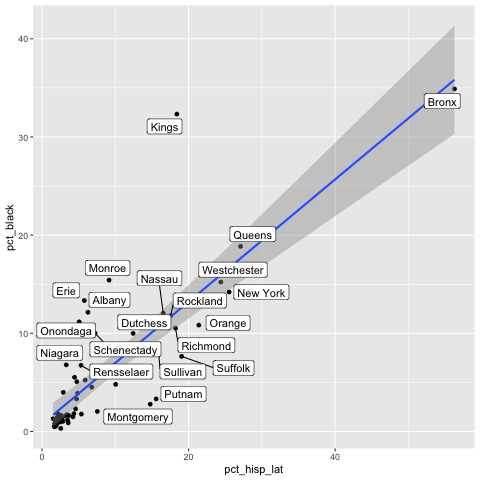

In [43]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_hisp_lat, y=pct_black) + 
    geom_point() +
    geom_smooth(method = "lm") +
    geom_label_repel(aes(label = County))

### Distant ( Y2 ) ~ X ( 1,2,3... )

After those disappointing regressions - let's try the late stage diagnosis

In [44]:
%%R 

model <- lm(Distant~pct_higher_ed, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ pct_higher_ed, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0338 -1.2085 -0.0419  0.6843  7.1305 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    6.73105    0.89442   7.526 3.48e-10 ***
pct_higher_ed -0.03626    0.02864  -1.266    0.211    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.815 on 59 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.02644,	Adjusted R-squared:  0.009941 
F-statistic: 1.602 on 1 and 59 DF,  p-value: 0.2105



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



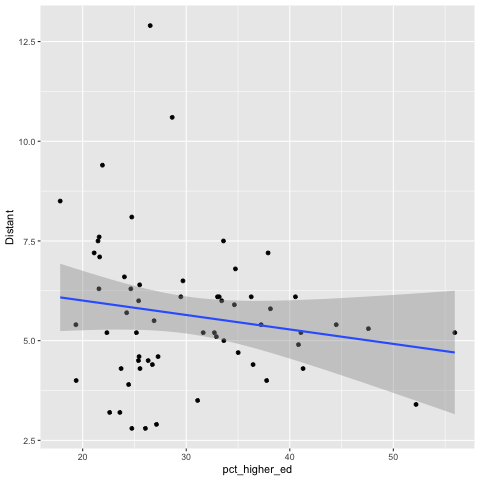

In [45]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_higher_ed, y=Distant) + 
    geom_point() +
    geom_smooth(method='lm')

In [46]:
%%R 

model <- lm(Distant~pct_female_poverty, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ pct_female_poverty, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0083 -1.0556 -0.0340  0.6467  7.4230 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.65713    0.88297   5.274 1.99e-06 ***
pct_female_poverty  0.07364    0.06396   1.151    0.254    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.819 on 59 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.02197,	Adjusted R-squared:  0.005397 
F-statistic: 1.326 on 1 and 59 DF,  p-value: 0.2542



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



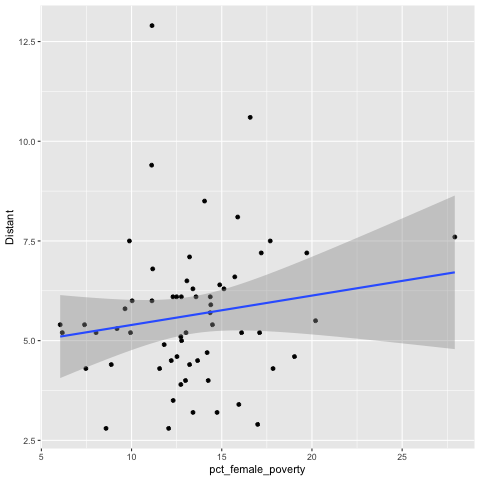

In [47]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_female_poverty, y=Distant) + 
    geom_point() +
    geom_smooth(method='lm')

In [48]:
%%R 

model <- lm(Distant~med_inc_estimate, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ med_inc_estimate, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9145 -1.1710 -0.0631  0.7082  7.2177 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       6.222e+00  1.010e+00   6.163 6.94e-08 ***
med_inc_estimate -8.594e-06  1.444e-05  -0.595    0.554    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.834 on 59 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.005972,	Adjusted R-squared:  -0.01088 
F-statistic: 0.3545 on 1 and 59 DF,  p-value: 0.5539



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



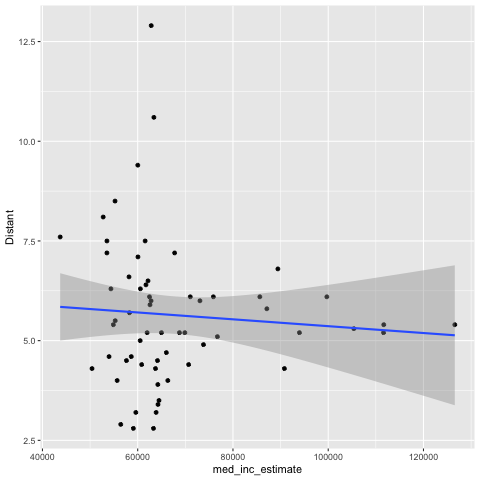

In [49]:
%%R 

ggplot(clean_df) + 
    aes(x=med_inc_estimate, y=Distant) + 
    geom_point() +
    geom_smooth(method='lm')

In [50]:
%%R 

model <- lm(Distant~pct_white, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ pct_white, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6716 -1.0332 -0.2523  0.8156  7.4093 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.09970    1.27738   5.558 6.91e-07 ***
pct_white   -0.01753    0.01506  -1.164    0.249    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.819 on 59 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.02245,	Adjusted R-squared:  0.005881 
F-statistic: 1.355 on 1 and 59 DF,  p-value: 0.2491



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



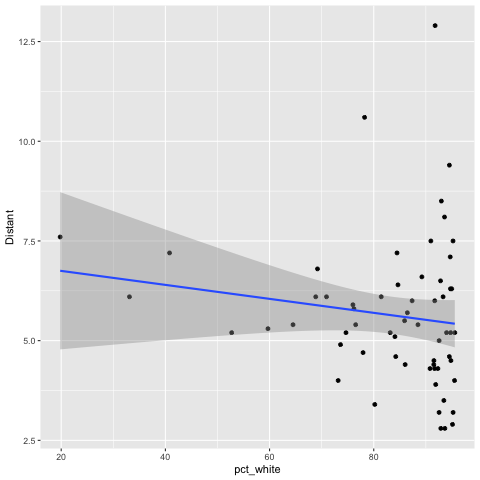

In [51]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_white, y=Distant) + 
    geom_point() +
    geom_smooth(method='lm')

In [52]:
%%R 

model <- lm(Distant~pct_black, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ pct_black, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7049 -1.1234 -0.2781  0.7769  7.4444 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.44473    0.30089  18.096   <2e-16 ***
pct_black    0.03409    0.03352   1.017    0.313    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.824 on 59 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.01723,	Adjusted R-squared:  0.0005705 
F-statistic: 1.034 on 1 and 59 DF,  p-value: 0.3133



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



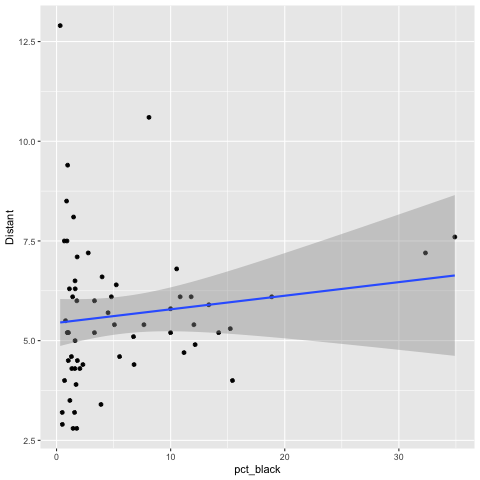

In [53]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_black, y=Distant) + 
    geom_point() +
    geom_smooth(method='lm')

In [54]:
%%R 

model <- lm(Distant~pct_hisp_lat, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ pct_hisp_lat, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6169 -1.0533 -0.2348  0.7459  7.4770 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.32004    0.30351  17.529   <2e-16 ***
pct_hisp_lat  0.04033    0.02506   1.609    0.113    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.801 on 59 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.04205,	Adjusted R-squared:  0.02581 
F-statistic:  2.59 on 1 and 59 DF,  p-value: 0.1129



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



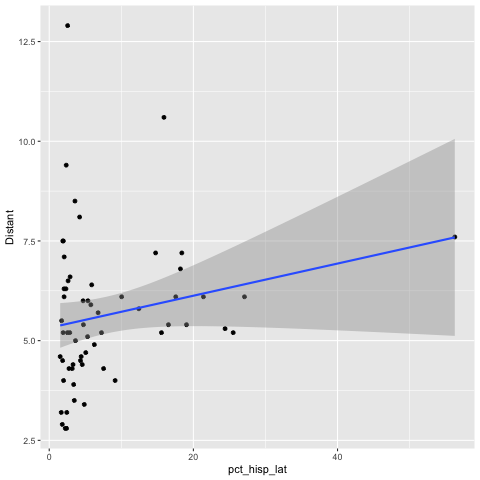

In [55]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_hisp_lat, y=Distant) + 
    geom_point() +
    geom_smooth(method='lm')

In [56]:
# Maybe you have to take the outliers and then see over the years if the population or something has predicted it?

### Quick Multi Linear : Local ( Y1 ) ~ (X1 + X2 + X3...)

In [57]:
%%R 

upstate_df <- clean_df %>%
    filter(is_nyc == FALSE)

In [58]:
%%R 

model <- lm(Local~pct_white, data=upstate_df)
summary(model)


Call:
lm(formula = Local ~ pct_white, data = upstate_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.1533  -1.6830   0.3865   2.0990   9.1809 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 64.28671    5.20603  12.349   <2e-16 ***
pct_white    0.06348    0.05954   1.066    0.291    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.92 on 54 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.02062,	Adjusted R-squared:  0.002479 
F-statistic: 1.137 on 1 and 54 DF,  p-value: 0.2911



In [59]:
%%R 

model <- lm(Local~pct_female_poverty+pct_white, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ pct_female_poverty + pct_white, data = clean_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.5649  -1.7052   0.3649   2.2985   8.9872 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        62.94915    3.87683  16.237  < 2e-16 ***
pct_female_poverty -0.08493    0.14245  -0.596  0.55335    
pct_white           0.09105    0.03355   2.714  0.00874 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.844 on 58 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.1435,	Adjusted R-squared:  0.114 
F-statistic: 4.859 on 2 and 58 DF,  p-value: 0.01119



In [60]:
%%R 
model <- lm(Distant~pct_higher_ed+pct_female_poverty+med_inc_estimate+pct_hisp_lat, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ pct_higher_ed + pct_female_poverty + med_inc_estimate + 
    pct_hisp_lat, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8581 -0.9640 -0.2013  0.6822  7.3178 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)         7.420e+00  2.822e+00   2.629   0.0110 *
pct_higher_ed      -5.923e-02  4.241e-02  -1.396   0.1681  
pct_female_poverty -2.155e-02  1.118e-01  -0.193   0.8478  
med_inc_estimate   -2.983e-06  3.159e-05  -0.094   0.9251  
pct_hisp_lat        6.261e-02  3.705e-02   1.690   0.0966 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.787 on 56 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.1041,	Adjusted R-squared:  0.04013 
F-statistic: 1.627 on 4 and 56 DF,  p-value: 0.1802



In [61]:
%%R 

model <- lm(Regional~pct_higher_ed+pct_female_poverty+med_inc_estimate+pct_white+pct_black+pct_hisp_lat, data=clean_df)
summary(model)


Call:
lm(formula = Regional ~ pct_higher_ed + pct_female_poverty + 
    med_inc_estimate + pct_white + pct_black + pct_hisp_lat, 
    data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.2305 -1.3028 -0.0046  1.8522  5.4012 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)         2.220e+01  1.312e+01   1.692   0.0964 .
pct_higher_ed       8.507e-02  8.107e-02   1.049   0.2987  
pct_female_poverty -1.066e-01  1.976e-01  -0.540   0.5915  
med_inc_estimate   -6.674e-05  5.478e-05  -1.218   0.2284  
pct_white           2.936e-02  1.170e-01   0.251   0.8029  
pct_black           7.398e-02  1.889e-01   0.392   0.6968  
pct_hisp_lat        1.340e-01  1.135e-01   1.180   0.2431  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.089 on 54 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.133,	Adjusted R-squared:  0.0367 
F-statistic: 1.381 on 6 and 54 DF

## Non NYC Counties

In [62]:
%%R 

non_nyc <- clean_df %>% 
    filter(is_nyc == FALSE)

In [63]:
%%R 

model <- lm(Local~I(pct_white^2), data=non_nyc)
summary(model)


Call:
lm(formula = Local ~ I(pct_white^2), data = non_nyc)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.0858  -1.7264   0.4296   2.1124   9.1458 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    6.668e+01  2.823e+00  23.618   <2e-16 ***
I(pct_white^2) 4.090e-04  3.629e-04   1.127    0.265    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.915 on 54 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.02298,	Adjusted R-squared:  0.004887 
F-statistic:  1.27 on 1 and 54 DF,  p-value: 0.2647



In [64]:
%%R 

model <- lm(I(sin(Local))~pct_white, data=non_nyc)
summary(model)


Call:
lm(formula = I(sin(Local)) ~ pct_white, data = non_nyc)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.35720 -0.67077  0.06237  0.66812  0.98630 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  1.76733    0.95137   1.858   0.0687 .
pct_white   -0.01855    0.01088  -1.704   0.0940 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7163 on 54 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.05105,	Adjusted R-squared:  0.03348 
F-statistic: 2.905 on 1 and 54 DF,  p-value: 0.09405



`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 

R[write to console]: 3: Removed 1 row containing missing values or values outside the scale range
(`geom_label_repel()`). 

R[write to console]: 4: ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps 



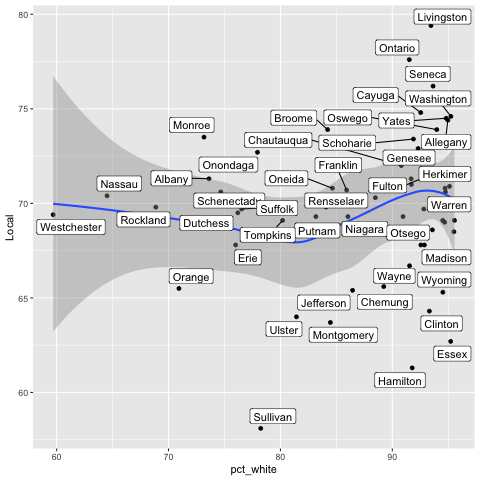

In [81]:
%%R 

ggplot(non_nyc) + 
    aes(x=pct_white, y=Local) + 
    geom_point() +
    geom_smooth() +
    geom_label_repel(aes(label = County))

In [66]:
%%R 

model <- lm(Local~I(cos(pct_higher_ed)), data=non_nyc)
summary(model)


Call:
lm(formula = Local ~ I(cos(pct_higher_ed)), data = non_nyc)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4225  -2.0433   0.0865   2.5083   8.4201 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            69.7389     0.5138 135.719   <2e-16 ***
I(cos(pct_higher_ed))   1.3057     0.6886   1.896   0.0633 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.835 on 54 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.06242,	Adjusted R-squared:  0.04505 
F-statistic: 3.595 on 1 and 54 DF,  p-value: 0.06331



`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



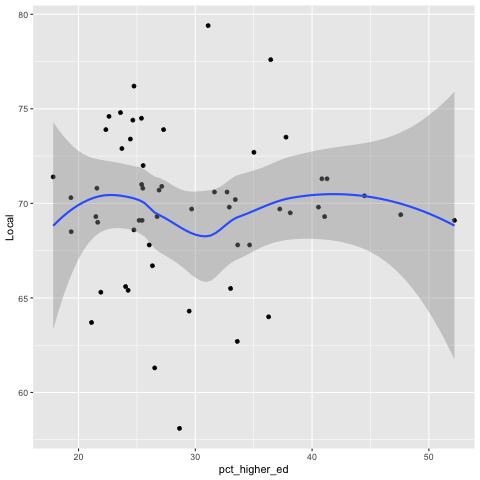

In [78]:
%%R 

ggplot(non_nyc) + 
    aes(x=pct_higher_ed, y=Local) + 
    geom_point() +
    geom_smooth()

In [68]:
%%R 

model <- lm(Local~I(sin(pct_female_poverty)), data=non_nyc)
summary(model)


Call:
lm(formula = Local ~ I(sin(pct_female_poverty)), data = non_nyc)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.571  -1.779  -0.120   2.545  10.082 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 69.6450     0.5247 132.742   <2e-16 ***
I(sin(pct_female_poverty))   1.2753     0.7510   1.698   0.0952 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.859 on 54 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.0507,	Adjusted R-squared:  0.03312 
F-statistic: 2.884 on 1 and 54 DF,  p-value: 0.09522



`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 

R[write to console]: 3: Removed 1 row containing missing values or values outside the scale range
(`geom_label_repel()`). 

R[write to console]: 4: ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps 



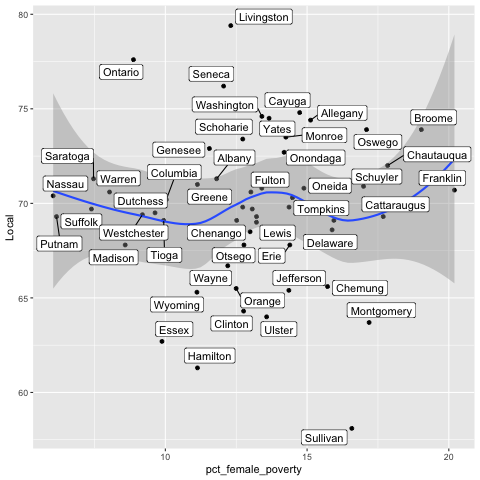

In [69]:
%%R 

ggplot(non_nyc) + 
    aes(x=pct_female_poverty, y=Local) + 
    geom_point() +
    geom_smooth() +
    geom_label_repel(aes(label = County))

In [70]:
%%R 

model <- lm(Local~I(sin(med_inc_estimate)), data=non_nyc)
summary(model)


Call:
lm(formula = Local ~ I(sin(med_inc_estimate)), data = non_nyc)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.8931  -1.6702   0.2374   2.3649  10.4734 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               69.9146     0.5273 132.582   <2e-16 ***
I(sin(med_inc_estimate))  -0.9894     0.7562  -1.308    0.196    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.9 on 54 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.03073,	Adjusted R-squared:  0.01278 
F-statistic: 1.712 on 1 and 54 DF,  p-value: 0.1963



`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 



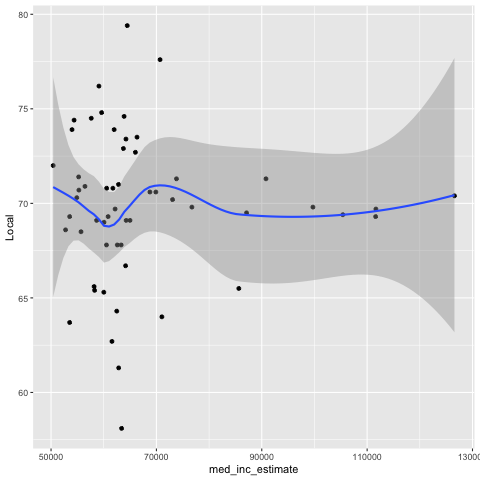

In [79]:
%%R 

ggplot(non_nyc) + 
    aes(x=med_inc_estimate, y=Local) + 
    geom_point() +
    geom_smooth() +
    geom_label_repel(aes(label = County))

In [72]:
%%R 

model <- lm(Local~ I(pct_white^2) + I(cos(pct_higher_ed)) + I(sin(pct_female_poverty)) + 
            I(sin(med_inc_estimate)), data=non_nyc)
summary(model)


Call:
lm(formula = Local ~ I(pct_white^2) + I(cos(pct_higher_ed)) + 
    I(sin(pct_female_poverty)) + I(sin(med_inc_estimate)), data = non_nyc)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.3377 -2.3490  0.2017  1.9339  9.4574 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                66.7242467  2.7956712  23.867   <2e-16 ***
I(pct_white^2)              0.0003865  0.0003575   1.081    0.285    
I(cos(pct_higher_ed))       1.0164927  0.6904470   1.472    0.147    
I(sin(pct_female_poverty))  1.2530028  0.7457298   1.680    0.099 .  
I(sin(med_inc_estimate))   -0.8037404  0.7354934  -1.093    0.280    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.769 on 51 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.1451,	Adjusted R-squared:  0.07803 
F-statistic: 2.164 on 4 and 51 DF,  p-value: 0.08632



In [73]:
%%R 

model <- lm(Local~ I(pct_white^2) + I(sin(pct_female_poverty)), data=non_nyc)
summary(model)


Call:
lm(formula = Local ~ I(pct_white^2) + I(sin(pct_female_poverty)), 
    data = non_nyc)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.6882 -2.3096  0.0965  2.8701  9.5925 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                6.582e+01  2.797e+00  23.531   <2e-16 ***
I(pct_white^2)             4.982e-04  3.578e-04   1.392   0.1696    
I(sin(pct_female_poverty)) 1.414e+00  7.511e-01   1.882   0.0653 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.826 on 53 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.0842,	Adjusted R-squared:  0.04964 
F-statistic: 2.436 on 2 and 53 DF,  p-value: 0.09721



In [74]:
# Why doesn't insurance predict even a little the stage at which it is diagnosed?

In [75]:
%%R 

model <- lm(Distant~ I(pct_white^2) + I(cos(pct_higher_ed)) + I(sin(pct_female_poverty)) + I(sin(med_inc_estimate)), data=non_nyc)
summary(model)


Call:
lm(formula = Distant ~ I(pct_white^2) + I(cos(pct_higher_ed)) + 
    I(sin(pct_female_poverty)) + I(sin(med_inc_estimate)), data = non_nyc)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4048 -1.0471 -0.1439  0.7420  6.7245 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 6.0455007  1.3634809   4.434 4.94e-05 ***
I(pct_white^2)             -0.0000488  0.0001743  -0.280   0.7807    
I(cos(pct_higher_ed))      -0.4338855  0.3367389  -1.288   0.2034    
I(sin(pct_female_poverty)) -0.6550363  0.3637010  -1.801   0.0776 .  
I(sin(med_inc_estimate))   -0.1067022  0.3587086  -0.297   0.7673    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.838 on 51 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.09913,	Adjusted R-squared:  0.02848 
F-statistic: 1.403 on 4 and 51 DF,  p-value: 0.2462



In [76]:
%%R 

model <- lm(Distant~I(pct_insured^2), data=non_nyc)
summary(model)


Call:
lm(formula = Distant ~ I(pct_insured^2), data = non_nyc)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7628 -1.1707 -0.3036  0.6029  7.3363 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)        4.8930     5.6520   0.866    0.390
I(pct_insured^2)   0.7264     6.2092   0.117    0.907

Residual standard error: 1.882 on 54 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.0002534,	Adjusted R-squared:  -0.01826 
F-statistic: 0.01369 on 1 and 54 DF,  p-value: 0.9073



`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 1 row containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 1 row containing missing values or values outside the scale range
(`geom_point()`). 

R[write to console]: 3: Removed 1 row containing missing values or values outside the scale range
(`geom_label_repel()`). 

R[write to console]: 4: ggrepel: 34 unlabeled data points (too many overlaps). Consider increasing max.overlaps 



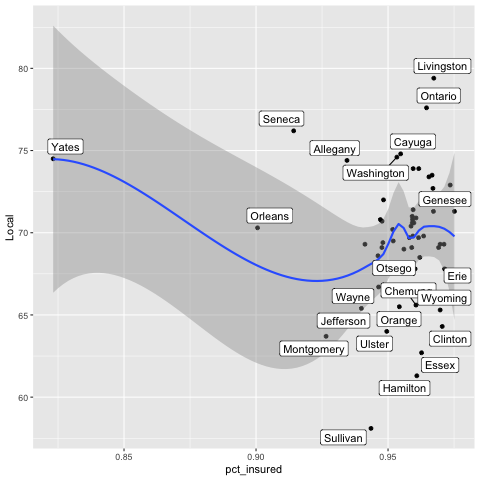

In [77]:
%%R 

ggplot(non_nyc) + 
    aes(x=pct_insured, y=Local) + 
    geom_point() +
    geom_smooth() +
    geom_label_repel(aes(label = County))